In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import odl
import odl.contrib.tensorflow
from tensorflow.examples.tutorials.mnist import input_data
from IPython.display import display, clear_output

/export/scratch1/hendriks/miniconda3/envs/odl/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/export/scratch1/hendriks/miniconda3/envs/odl/lib/python3.6/site-packages/odl/trafos/backends/pyfftw_bindings.py:30: RuntimeWarning: PyFFTW < 0.10.4 is known to cause problems with some ODL functionality, see issue #1002.
  RuntimeWarning)


In [2]:
# Start a tensorflow session
session = tf.InteractiveSession()

# Set the random seed to enable reproducible code
np.random.seed(0)

# Create ODL data structures
num_angles = 5
space = odl.uniform_discr([-14, -14], [14, 14], [28, 28],
                          dtype='float32')

geometry = odl.tomo.parallel_beam_geometry(space, num_angles=num_angles)
operator = odl.tomo.RayTransform(space, geometry)
fbp_op = odl.tomo.fbp_op(operator)

# Create tensorflow wrappers
tf_op = odl.contrib.tensorflow.as_tensorflow_layer(operator)
tf_op_adj = odl.contrib.tensorflow.as_tensorflow_layer(operator.adjoint)
tf_fbp_op = odl.contrib.tensorflow.as_tensorflow_layer(fbp_op, name="FBP")

In [3]:
# Get MNIST data
mnist = input_data.read_data_sets('MNIST_data')


def generate_data(images):
    """Generate data from images
    
    Parameters
    ----------
    images : np.array of shape [Batch, 28, 28, 1]
        The images (in reconstruction space) which we should create data for.
        
    Returns
    -------
    sinograms : np.array of shape [Batch, 5, 41, 1]
        Noisy sinograms corresponding to ``images``
    """
    data = [operator(image.squeeze()).asarray() +
            np.random.randn(*operator.range.shape) for image in images]
    return np.array(data)[..., None]

# Read the first 1000 mnist test points
batch = mnist.test.next_batch(100)
test_images = batch[0].reshape([-1, 28, 28, 1])

# Create test data (persistent to save time)
test_data = generate_data(test_images)

def evaluate(result_tensor, data_placeholder):
    """Evaluate a reconstruction method.

    Parameters
    ----------
    result_tensor : `tf.Tensor`, shape (None, 28, 28, 1)
        The tensorflow tensor containing the result of the reonstruction
        operator.
    data_placeholder : `tf.Tensor`, shape (None, 5, 41, 1)
        The tensorflow tensor containing the input to the reconstruction
        operator.

    Returns
    -------
    MSE : float
        Mean squared error of the reconstruction.
    """
    result = result_tensor.eval(
        feed_dict={data_placeholder: test_data})

    return np.mean((result - test_images) ** 2)

def display_progress(i, max_iter, result_tensor, data_placeholder, every=200):
    """Utility function to display training progress."""
    if (i + 1) % every == 0:
        error = evaluate(result_tensor, data_placeholder)
        clear_output()
        display('{}/{} Error: {:.5f}'.format(i + 1, max_iter, error))
        
def get_tensor_name(tensor, default_name="Truth"):
    """Utility function to get the name of a tensor."""
    try:
        name = tensor.name.split('/')[0]
    except AttributeError:
        name = default_name
    return name
default_indices = np.arange(20)
def visualize(result_tensors, data_placeholder, indices=default_indices):
    """Visualize the result of a reconstruction.
    
    Parameters
    ----------
    result_tensors : list of `tf.Tensor`, shape (None, 28, 28, 1)
        The tensorflow tensor containing the result of the reconstruction
        operator.
    data_placeholder : `tf.Tensor`, shape (None, 5, 41, 1)
        The tensorflow tensor containing the input to the reconstruction
        operator.
    """        
    results = [result_tensor.eval(
        feed_dict={data_placeholder: test_data[indices]}) for result_tensor in result_tensors]
    
    results_ = [test_images[indices]] + results
    names = [get_tensor_name(tensor) for tensor in [None]+result_tensors]
    
    figsize = 2
    fig, rows = plt.subplots(len(indices), len(results_), sharex=True, sharey=True, figsize=(len(results_)*figsize, figsize*len(indices)))
    # stupid matplotlib:
    if len(indices) == 1:
        rows = [rows]
    for i, row in enumerate(rows):
        for name, res, ax in zip(names, results_, row):
            if i == 0:
                ax.set_title(name)
            ax.imshow(res[i].squeeze(), clim=[0,1], cmap="bone")
            ax.set_axis_off()
    plt.show()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
with tf.name_scope('placeholders'):
    x_true = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name="x_true")
    y = tf.placeholder(tf.float32, shape=[None, *operator.range.shape, 1], name="y")

FBP Mean squared error: 0.15347172319889069


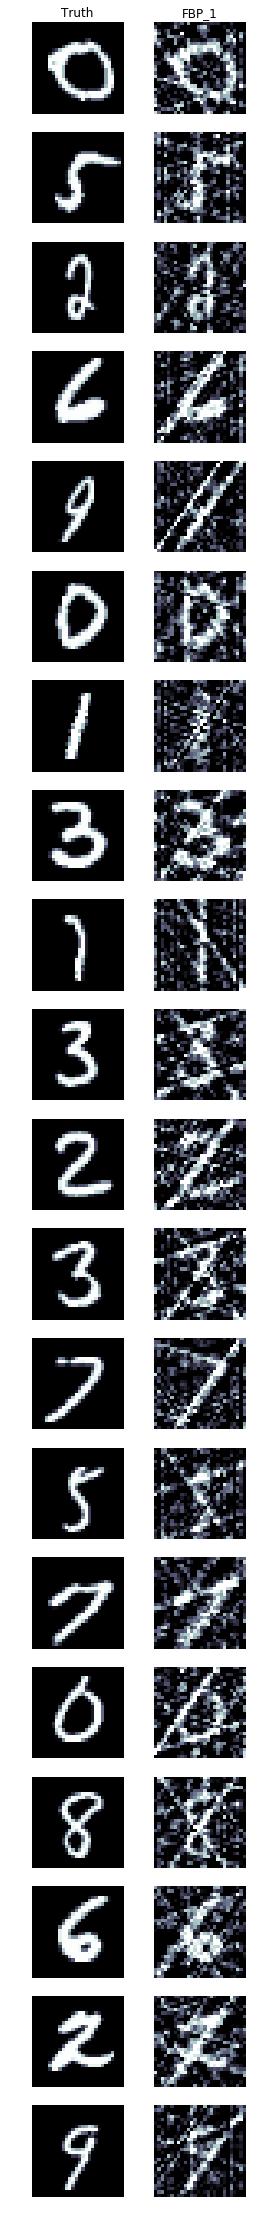

In [5]:
print('FBP Mean squared error: {}'.format(evaluate(tf_fbp_op(y), y)))
visualize([tf_fbp_op(y)], y)

'10000/10000 Error: 0.00679'

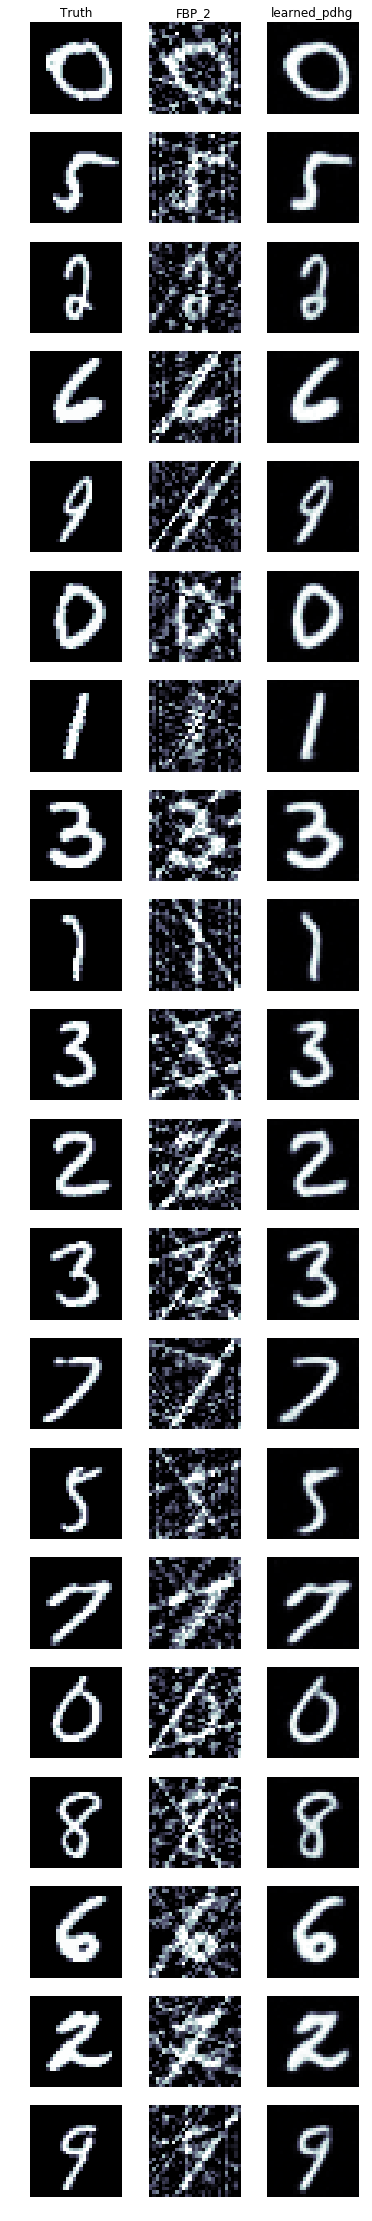

In [6]:
with tf.variable_scope('learned_pdhg'):
    with tf.name_scope('learned_pdhg_reconstruction'):
        current = tf_fbp_op(y)
        h = tf.identity(y)
        
        for i in range(6):            
            fwd = tf_op(current)
            new_h = tf.concat([h, y - fwd], axis=-1)
            print(new_h.shape, i)
            
            new_h = tf.contrib.layers.conv2d(new_h, num_outputs=32, kernel_size=3)
            print(new_h.shape, i)
            new_h = tf.contrib.layers.conv2d(new_h, num_outputs=32, kernel_size=3)
            print(new_h.shape, i)
            new_h = tf.contrib.layers.conv2d(new_h, num_outputs=1, kernel_size=3,
                                            activation_fn=None)
            print(new_h.shape, i)
            h = new_h
            
            dx = tf.concat([current, tf_op_adj(h)], axis=-1)
            dx = tf.contrib.layers.conv2d(dx, num_outputs=32, kernel_size=3)
            dx = tf.contrib.layers.conv2d(dx, num_outputs=32, kernel_size=3)
            dx = tf.contrib.layers.conv2d(dx, num_outputs=1, kernel_size=3,
                                          activation_fn=None)
                        
            current = current + dx

        x_result_li = current

    with tf.name_scope('optimizer'):
        loss = tf.reduce_mean((x_result_li - x_true) ** 2)
        optimizer = tf.train.AdamOptimizer(beta2=0.99).minimize(loss)  # different beta2 for faster convergence

# Initialize all current variables
session.run([v.initializer for v in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='learned_pdhg')]);

max_iter = 10000
for i in range(max_iter):
    batch = mnist.train.next_batch(5)
    images = batch[0].reshape([-1, 28, 28, 1])
    data = generate_data(images)

    session.run(optimizer, feed_dict={x_true: images, y: data})

    display_progress(i, max_iter, x_result_li, y)
    
visualize([tf_fbp_op(y), x_result_li], y)

In [25]:
FWP_norm = odl.operator.power_method_opnorm(operator.adjoint)
FBP_norm = odl.operator.power_method_opnorm(fbp_op)
FWP_norm, FBP_norm

(11.837590772528486, 1.2570753603083809)